In [1]:
from py2neo import Graph
import networkx as nx

# 连接数据库
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# 查询所有节点和边
query = """
MATCH (a)-[r]->(b)
RETURN id(a) as source, id(b) as target, type(r) as relation, properties(r) as edge_attr
"""
edges = graph.run(query).data()

# 构建 NetworkX 图
G = nx.DiGraph()
for edge in edges:
    G.add_edge(edge["source"], edge["target"], **(edge["edge_attr"] or {}))

# 添加节点属性
node_query = "MATCH (n) RETURN id(n) as id, labels(n) as labels, properties(n) as attr"
nodes = graph.run(node_query).data()

for node in nodes:
    G.add_node(node["id"], **node["attr"])


In [2]:
# -----------------------------
# 图结构基本统计信息输出
# -----------------------------

print("✅ 图结构统计信息")
print(f"👉 节点总数：{G.number_of_nodes()}")
print(f"👉 边总数：{G.number_of_edges()}")

# 节点入度、出度
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

avg_in_degree = sum(in_degrees.values()) / len(in_degrees)
avg_out_degree = sum(out_degrees.values()) / len(out_degrees)

print(f"👉 平均入度：{avg_in_degree:.2f}")
print(f"👉 平均出度：{avg_out_degree:.2f}")

# 节点标签统计（如果有标签）
label_count = {}
for node in nodes:
    for label in node["labels"]:
        label_count[label] = label_count.get(label, 0) + 1
print("👉 各类型节点数量：")
for label, count in label_count.items():
    print(f"   - {label}: {count} 个")

# 关系类型统计
relation_count = {}
for edge in edges:
    rel = edge['relation']
    relation_count[rel] = relation_count.get(rel, 0) + 1
print("👉 各类型关系数量：")
for rel, count in relation_count.items():
    print(f"   - {rel}: {count} 条")


✅ 图结构统计信息
👉 节点总数：44112
👉 边总数：276586
👉 平均入度：6.27
👉 平均出度：6.27
👉 各类型节点数量：
   - Disease: 8808 个
   - Drug: 3828 个
   - Food: 4870 个
   - Check: 3353 个
   - Department: 54 个
   - Producer: 17201 个
   - Symptom: 5998 个
👉 各类型关系数量：
   - recommand_eat: 40236 条
   - no_eat: 22247 条
   - do_eat: 22238 条
   - belongs_to: 8844 条
   - common_drug: 14649 条
   - drugs_of: 17315 条
   - recommand_drug: 59467 条
   - need_check: 39423 条
   - has_symptom: 54717 条
   - acompany_with: 12029 条


In [3]:
# 收集所有 Department 类型的部门名
department_names = []
for node in nodes:
    if "Department" in node["labels"]:
        dept_name = node["attr"].get("name") or node["attr"].get("department_name")
        if dept_name:
            department_names.append(dept_name)

# 按字典序排序部门名
department_names.sort()

# 拼接成一个用顿号分隔的字符串
departments_str = "、".join(department_names)

print(f"👉 部门列表（共 {len(department_names)} 个）：{departments_str}")


👉 部门列表（共 54 个）：不孕不育、中医科、中医综合、五官科、产科、传染科、儿科、儿科综合、其他科室、其他综合、内分泌科、内科、减肥、口腔科、呼吸内科、外科、妇产科、妇科、小儿内科、小儿外科、康复科、心内科、心理科、心胸外科、急诊科、性病科、感染科、整形美容科、普外科、泌尿内科、泌尿外科、消化内科、烧伤科、生殖健康、男科、皮肤性病科、皮肤科、眼科、神经内科、神经外科、精神科、耳鼻喉科、肛肠科、肝病、肝胆外科、肾内科、肿瘤内科、肿瘤外科、肿瘤科、营养科、血液科、遗传病科、风湿免疫科、骨外科


In [21]:
from py2neo import Graph
import networkx as nx
import torch
from torch_geometric.data import HeteroData
import torch.nn.functional as F
import pandas as pd

# 连接 Neo4j 图数据库
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12345678"))

# 获取 has_symptom 关系（Symptom -> Disease）
query = """
MATCH (d:Disease)-[:has_symptom]->(s:Symptom)
RETURN id(d) as did, d.name as dname, id(s) as sid, s.name as sname
"""
results = graph.run(query).data()

# 创建节点映射
symptoms, diseases = {}, {}
edges = []

for row in results:
    sid, sname = row["sid"], row["sname"]
    did, dname = row["did"], row["dname"]
    if sid not in symptoms:
        symptoms[sid] = sname
    if did not in diseases:
        diseases[did] = dname
    edges.append((sid, did))

print(f"共提取到 {len(symptoms)} 个症状，{len(diseases)} 个疾病，{len(edges)} 条 has_symptom 关系")


共提取到 5998 个症状，8765 个疾病，54717 条 has_symptom 关系


In [30]:
from torch_geometric.data import HeteroData

# 构建 ID 映射表
symptom_ids = list(symptoms.keys())
disease_ids = list(diseases.keys())
symptom_id_map = {nid: i for i, nid in enumerate(symptom_ids)}
disease_id_map = {nid: i for i, nid in enumerate(disease_ids)}

num_symptoms = len(symptom_ids)
num_diseases = len(disease_ids)

print(f"症状节点数：{num_symptoms}")
print(f"疾病节点数：{num_diseases}")


症状节点数：5998
疾病节点数：8765


In [40]:
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected
import torch

# 创建 HeteroData 容器
data = HeteroData()

# 为症状和疾病分配索引映射（ID → 连续索引）
symptom_id_map = {nid: i for i, nid in enumerate(symptoms)}
disease_id_map = {nid: i for i, nid in enumerate(diseases)}

# 构造边索引：source 是 symptom，target 是 disease
edge_index = torch.tensor([
    [symptom_id_map[sid] for sid, did in edges],
    [disease_id_map[did] for sid, did in edges]
], dtype=torch.long)

# 构造异构图数据结构
data['symptom'].num_nodes = len(symptoms)
data['disease'].num_nodes = len(diseases)
data['symptom', 'has_symptom', 'disease'].edge_index = edge_index

# 可选：转换为无向图（有助于传播）
data = ToUndirected()(data)


In [41]:
symptom_feat = torch.randn(len(symptoms), 64)
disease_feat = torch.randn(len(diseases), 64)
data['symptom'].x = symptom_feat
data['disease'].x = disease_feat


In [6]:
from py2neo import Graph
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected
from torch_geometric.nn import GATConv, HeteroConv, Linear
import torch.nn.functional as F
import random

# ===================== 第一步：从 Neo4j 导入图数据 =====================
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12345678"))

query = """
MATCH (d:Disease)-[:has_symptom]->(s:Symptom)
RETURN id(d) as did, d.name as dname, id(s) as sid, s.name as sname
"""
results = graph.run(query).data()

symptoms, diseases = {}, {}
edges = []

for row in results:
    sid, sname = row["sid"], row["sname"]
    did, dname = row["did"], row["dname"]
    if sid not in symptoms:
        symptoms[sid] = sname
    if did not in diseases:
        diseases[did] = dname
    edges.append((sid, did))

print(f"提取完成：{len(symptoms)} 个症状，{len(diseases)} 个疾病，{len(edges)} 条 has_symptom 关系")


提取完成：5998 个症状，8765 个疾病，54717 条 has_symptom 关系


In [8]:
# ===================== 第二步：构建 HeteroData 图 =====================
print("🔧 构建异构图 HeteroData...")
symptom_id_map = {nid: i for i, nid in enumerate(symptoms)}
disease_id_map = {nid: i for i, nid in enumerate(diseases)}

edge_index = torch.tensor([
    [symptom_id_map[sid] for sid, did in edges],
    [disease_id_map[did] for sid, did in edges]
], dtype=torch.long)

data = HeteroData()
data['symptom'].num_nodes = len(symptoms)
data['disease'].num_nodes = len(diseases)
data['symptom', 'has_symptom', 'disease'].edge_index = edge_index
data = ToUndirected()(data)


🔧 构建异构图 HeteroData...


In [56]:
import torch

# 保存整个图对象到文件
torch.save(data, "graph_data.pt")
print("图数据已保存为 graph_data.pt")


图数据已保存为 graph_data.pt


In [57]:
import torch
from torch_geometric.data import HeteroData

# 加载图对象
data = torch.load("graph_data.pt")
print("图数据已加载！")


图数据已加载！


C:\Users\admin\AppData\Local\Temp\ipykernel_12572\3126188825.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("graph_data.pt")


In [54]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

print("📥 正在加载 BERT 中文模型...")
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')
model.eval()  # 关闭 dropout

# 将名称转换为 [CLS] token 的嵌入向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size] 中的 [CLS] 向量

# 症状嵌入
print("🌈 构建症状节点嵌入...")
symptom_feat_list = []
for sid in tqdm(symptoms):
    name = symptoms[sid]
    embedding = get_bert_embedding(name)
    symptom_feat_list.append(embedding.squeeze(0))
symptom_feat = torch.stack(symptom_feat_list)  # [num_symptom, 768]

# 疾病嵌入
print("🌈 构建疾病节点嵌入...")
disease_feat_list = []
for did in tqdm(diseases):
    name = diseases[did]
    embedding = get_bert_embedding(name)
    disease_feat_list.append(embedding.squeeze(0))
disease_feat = torch.stack(disease_feat_list)  # [num_disease, 768]

# 加入 HeteroData
data['symptom'].x = symptom_feat
data['disease'].x = disease_feat


📥 正在加载 BERT 中文模型...


g:\anaconda3\envs\pytorch2\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


🌈 构建症状节点嵌入...


100%|██████████| 5998/5998 [01:48<00:00, 55.31it/s]


🌈 构建疾病节点嵌入...


100%|██████████| 8765/8765 [02:53<00:00, 50.49it/s]


In [59]:
torch.save(symptom_feat, "symptom_feat.pt")
torch.save(disease_feat, "disease_feat.pt")
print("特征已保存为 symptom_feat.pt 和 disease_feat.pt")


特征已保存为 symptom_feat.pt 和 disease_feat.pt


In [9]:
import torch
from torch_geometric.data import HeteroData

# 加载图对象
data = torch.load("graph_data.pt")

symptom_feat = torch.load("symptom_feat.pt")
disease_feat = torch.load("disease_feat.pt")

data['symptom'].x = symptom_feat
data['disease'].x = disease_feat
print("成功加载并绑定 BERT 特征")

成功加载并绑定 BERT 特征


C:\Users\admin\AppData\Local\Temp\ipykernel_35120\2932775597.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("graph_data.pt")
C:\Users\admin\AppData\Lo

In [10]:
print("symptom_feat:", data['symptom'].x.shape)  # [5998, 768]
print("disease_feat:", data['disease'].x.shape)  # [8808, 768]


symptom_feat: torch.Size([5998, 768])
disease_feat: torch.Size([8765, 768])


In [11]:
from torch_geometric.nn import GATConv, HeteroConv, Linear
import torch.nn.functional as F
import torch.nn as nn

class Symptom2DiseaseGNN(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = HeteroConv({
            ('symptom', 'has_symptom', 'disease'): GATConv((-1, -1), hidden_dim, add_self_loops=False),
            ('disease', 'rev_has_symptom', 'symptom'): GATConv((-1, -1), hidden_dim, add_self_loops=False),
        }, aggr='sum')
        self.lin = Linear(hidden_dim, out_dim)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        out = self.lin(x_dict['symptom'])  # 每个 symptom 节点输出一个 [num_diseases] 向量
        return out

# 所有症状节点 → 对应的疾病标签（多标签矩阵）
num_symptoms = len(symptoms)
num_diseases = len(diseases)
labels = torch.zeros((num_symptoms, num_diseases))

for sid, did in edges:
    s_idx = symptom_id_map[sid]
    d_idx = disease_id_map[did]
    labels[s_idx][d_idx] = 1




In [12]:
model = Symptom2DiseaseGNN(hidden_dim=128, out_dim=num_diseases)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(1, 101):
    model.train()
    out = model(data.x_dict, data.edge_index_dict)  # shape: [num_symptoms, num_diseases]

    loss = F.binary_cross_entropy_with_logits(out, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")


Epoch 001 | Loss: 0.7108
Epoch 010 | Loss: 0.0158
Epoch 020 | Loss: 0.0282
Epoch 030 | Loss: 0.0212
Epoch 040 | Loss: 0.0127
Epoch 050 | Loss: 0.0101
Epoch 060 | Loss: 0.0086
Epoch 070 | Loss: 0.0077
Epoch 080 | Loss: 0.0073
Epoch 090 | Loss: 0.0070
Epoch 100 | Loss: 0.0069


In [38]:
def predict_disease_by_symptoms(input_symptoms, topk=5):
    # 1. 将症状名映射为 symptom 节点索引
    symptom_indices = []
    for sid, name in symptoms.items():
        if name in input_symptoms:
            symptom_indices.append(symptom_id_map[sid])
    
    if not symptom_indices:
        print("⚠️ 未找到任何匹配的症状！")
        return
    
    # 2. 模型预测
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)  # shape: [num_symptoms, num_diseases]
        probs = torch.sigmoid(out)

        # 3. 多个症状节点的预测结果 → 聚合（平均）
        joint_pred = probs[symptom_indices].mean(dim=0)  # [num_diseases]
        
        # 4. 取 top-k
        topk_vals, topk_idxs = torch.topk(joint_pred, topk)
        
        print("✅ 输入症状：", input_symptoms)
        print("🔍 Top-{} 疾病预测：".format(topk))
        for val, idx in zip(topk_vals.tolist(), topk_idxs.tolist()):
            for did, i in disease_id_map.items():
                if i == idx:
                    print(f" - {diseases[did]}：{val:.4f}")

predict_disease_by_symptoms(["视力障碍","眼睛红肿","眼内有异物感"], topk=10)


✅ 输入症状： ['视力障碍', '眼睛红肿', '眼内有异物感']
🔍 Top-10 疾病预测：
 - 肛裂：0.0047
 - 胃溃疡性穿孔：0.0041
 - 恶心和呕吐：0.0041
 - 卵巢癌：0.0041
 - 急性脊髓炎：0.0040
 - 卵巢残余综合征：0.0040
 - 纵隔神经鞘源性肿瘤：0.0039
 - 原发性输卵管癌：0.0038
 - 角化棘皮瘤：0.0038
 - 甲亢：0.0038


In [39]:
import random

num_symptoms = len(symptoms)
indices = list(range(num_symptoms))
random.shuffle(indices)

train_ratio = 0.8
train_num = int(num_symptoms * train_ratio)

train_idx = indices[:train_num]
test_idx = indices[train_num:]

train_mask = torch.zeros(num_symptoms, dtype=torch.bool)
test_mask = torch.zeros(num_symptoms, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# 可保存到 HeteroData 中
data['symptom'].train_mask = train_mask
data['symptom'].test_mask = test_mask

for epoch in range(1, 101):
    model.train()
    out = model(data.x_dict, data.edge_index_dict)  # shape: [num_symptoms, num_diseases]

    pred = out[data['symptom'].train_mask]
    true = labels[data['symptom'].train_mask]

    loss = F.binary_cross_entropy_with_logits(pred, true)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f}")


Epoch 001 | Train Loss: 0.0068
Epoch 010 | Train Loss: 0.0067
Epoch 020 | Train Loss: 0.0066
Epoch 030 | Train Loss: 0.0064
Epoch 040 | Train Loss: 0.0063
Epoch 050 | Train Loss: 0.0062
Epoch 060 | Train Loss: 0.0061
Epoch 070 | Train Loss: 0.0060
Epoch 080 | Train Loss: 0.0059
Epoch 090 | Train Loss: 0.0058
Epoch 100 | Train Loss: 0.0057


In [40]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

model.eval()
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)
    pred = torch.sigmoid(out[data['symptom'].test_mask])  # shape: [test_num, num_diseases]
    true = labels[data['symptom'].test_mask]

    # 二值化
    pred_binary = (pred > 0.5).int()
    true_binary = true.int()

    f1 = f1_score(true_binary.cpu(), pred_binary.cpu(), average='micro')
    precision = precision_score(true_binary.cpu(), pred_binary.cpu(), average='micro')
    recall = recall_score(true_binary.cpu(), pred_binary.cpu(), average='micro')

    print(f"🎯 Test F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"🎯 Test Accuracy: {accuracy_score(true_binary.cpu(), pred_binary.cpu()):.4f}")


🎯 Test F1: 0.0007 | Precision: 0.4000 | Recall: 0.0004
🎯 Test Accuracy: 0.0025


In [4]:
attrs = [G.nodes[n].keys() for n in G.nodes()]
print(set(frozenset(attr) for attr in attrs))


{frozenset({'name', 'cured_prob', 'cure_department', 'prevent', 'easy_get', 'y', 'desc', 'cure_lasttime', 'x', 'cure_way', 'cause'}), frozenset({'name', 'x', 'y'})}


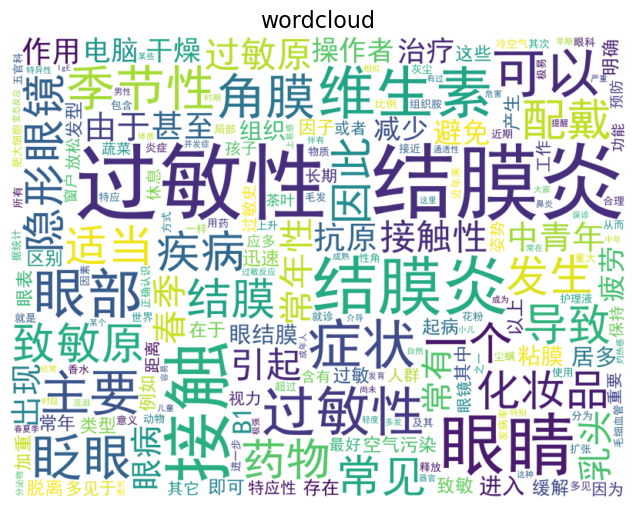

In [8]:
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 从 NetworkX 图中找到指定名字的节点
target_name = "过敏性结膜炎"  # 👈 你可以在这里改成其他节点名
target_node_id = None
target_text = ""

# 遍历节点，找出 name 属性为目标名称的节点 ID 和属性
for node_id, attr in G.nodes(data=True):
    if attr.get("name") == target_name:
        target_node_id = node_id
        # 拼接所有属性文本
        for value in attr.values():
            if isinstance(value, str):
                target_text += value
            elif isinstance(value, list):
                target_text += "".join(str(v) for v in value)
            else:
                target_text += str(value)
        break

if target_node_id is None:
    print(f"未找到名为“{target_name}”的节点")
else:
    # 分词 + 生成词云
    words = jieba.lcut(target_text)
    filtered_words = [word for word in words if len(word) > 1]  # 👈 只保留长度大于1的词

    word_str = " ".join(filtered_words)

    wc = WordCloud(
        font_path="simhei.ttf",  # 中文字体路径
        background_color="white",
        width=800,
        height=600
    )
    wc.generate(word_str)

    # 显示词云
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"wordcloud", fontsize=16)
    plt.show()



In [5]:
for node in G.nodes(data=True):
    node_id = node[0]
    x = G.nodes[node_id].get('x', [-1])
    y = G.nodes[node_id].get('y', -1)
    G.nodes[node_id].clear()  # 删除所有属性
    G.nodes[node_id]['x'] = x
    G.nodes[node_id]['y'] = y


In [6]:
label_map = {
    'Disease': 0, 'Drug': 1, 'Food': 2,
    'Check': 3, 'Department': 4, 'Producer': 5, 'Symptom': 6
}
for node in nodes:
    label = node["labels"][0]
    G.nodes[node["id"]]['x'] = [label_map[label]]  # 初始特征为类型编码
    G.nodes[node["id"]]['y'] = label_map[label]    # 标签用于可视化着色


In [7]:

# 转 PyG
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = data.x.float().cuda()
data.edge_index = data.edge_index.cuda()
data.y = data.y.cuda()

In [8]:
print(data)
print(data.x.shape)  # 例如 [44112, 1]，表示有 44112 个节点，每个有 1 维特征


Data(x=[44112, 1], edge_index=[2, 276586], y=[44112], name=[276586])
torch.Size([44112, 1])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx

# 定义 GNN 模型（简单的 GCN）
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
    
# 初始化 GNN 模型
input_dim = data.x.shape[1]  # 特征维度
hidden_dim = 64  # 隐藏层大小
output_dim = 16  # 输出维度（节点嵌入的维度）

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GNN(input_dim, hidden_dim, output_dim).to(device)

# 损失函数和优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # 假设有标签用于分类任务

# 训练模型
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)  # 如果你有标签的话，使用标签
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# 训练模型
train(model, data, optimizer, criterion)

cuda
Epoch 0, Loss: 3.6777701377868652
Epoch 10, Loss: 1.7230223417282104
Epoch 20, Loss: 1.505589246749878
Epoch 30, Loss: 1.3560020923614502
Epoch 40, Loss: 1.2203729152679443
Epoch 50, Loss: 1.1041475534439087
Epoch 60, Loss: 1.019149899482727
Epoch 70, Loss: 0.9556405544281006
Epoch 80, Loss: 0.9050736427307129
Epoch 90, Loss: 0.8640559911727905


In [10]:
from sklearn.cluster import KMeans

# 获取节点嵌入
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

# 进行 KMeans 聚类
num_clusters = 7  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings.cpu().numpy())

# 将聚类标签添加到 PyG 数据中
data.y = torch.tensor(cluster_labels, dtype=torch.long).to(device)


g:\anaconda3\envs\pytorch2\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


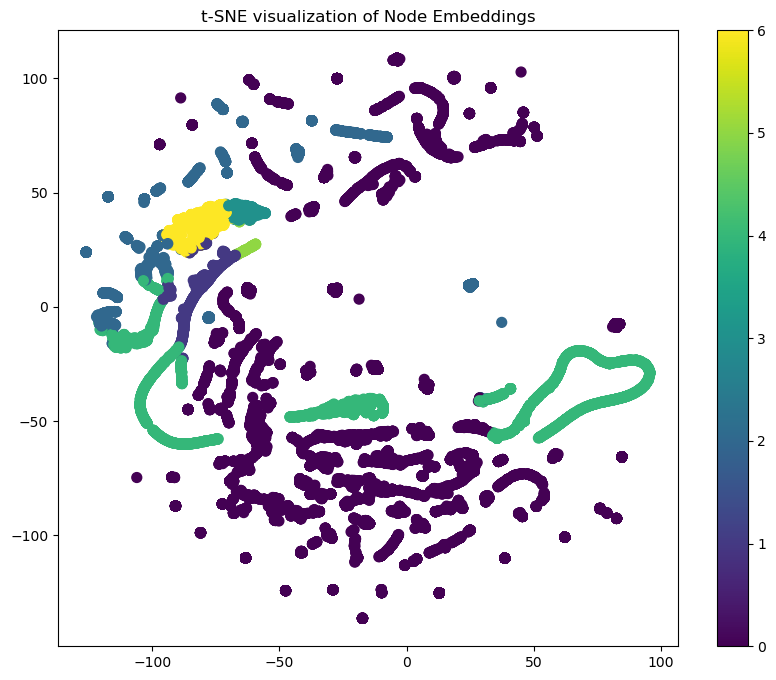

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 对节点嵌入进行 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings.cpu().numpy())

# 可视化
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title("t-SNE visualization of Node Embeddings")
plt.show()
